In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

## Loading datasets with Bigram and Trigram features

In [5]:
with open('bigram_bow_train.pkl','rb') as f:
    train_bigram = pickle.load(f)
    
with open('bigram_bow_test.pkl','rb') as f:
    test_bigram = pickle.load(f)
    
print('Shape of train data:',train_bigram.shape)
print('Shape of test data:',test_bigram.shape)

Shape of train data: (188318, 4373)
Shape of test data: (125546, 4373)


In [3]:
with open('trigram_bow_train.pkl','rb') as f:
    train_trigram = pickle.load(f)
    
with open('trigram_bow_test.pkl','rb') as f:
    test_trigram = pickle.load(f)
    
print('Shape of train data:',train_trigram.shape)
print('Shape of test data:',test_trigram.shape)

Shape of train data: (188318, 37458)
Shape of test data: (125546, 37458)


## Setting Benchmark Score

Our metrics Mean Absolute Error(MAE)  can take value from 0 to infinity. To evaluate, how a model is performing, it is good if I can establish some bench mark score.  

In [6]:
y = df['loss']
mean_loss  = np.empty(train_bigram.shape[0])
mean_loss.fill(y.mean())
print('Benchmark score: ',mean_absolute_error(y,mean_loss))

Benchmark score:  1966.1652855607203


## 1. Bigram Features( With 1000 features)
## 1.1 Linear Regression

In [5]:
# Selecting 1000 best features:
skb = SelectKBest(k=1000, score_func=f_regression)
train_bigram = skb.fit_transform(train_bigram,y)
test_bigram = skb.transform(test_bigram)

print('Shape of train data:',train_bigram.shape)
print('Shape of test data:',test_bigram.shape)

Shape of train data: (188318, 1000)
Shape of test data: (125546, 1000)


In [6]:
scaler = MaxAbsScaler()
scaled_train = scaler.fit_transform(train_bigram)
scaled_test = scaler.transform(test_bigram)
print('Shape of train data:',scaled_train.shape)
print('Shape of test data:',scaled_test.shape)

Shape of train data: (188318, 1000)
Shape of test data: (125546, 1000)


In [10]:
y = np.log(y)

In [11]:
model = LinearRegression()
model.fit(scaled_train, y) 
y_pred = np.exp(model.predict(scaled_train))
print('Mean Absolute Error from Linear Regression: ',mean_absolute_error(np.exp(y),y_pred))

Mean Absolute Error from Linear Regression:  1347.9274656658147


## 1.2 ElasticNet

In [ ]:
# params = {'l1_ratio':[0,0.1,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
#          'alpha':[0.001,0.01,0.1,1,10,100,1000]}
# model = ElasticNet()
# reg_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_absolute_error', )
# reg_model.fit(scaled_train,y)

c:\purnima\myworkspace\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30998.658930708283, tolerance: 10.333635506777263
  model = cd_fast.sparse_enet_coordinate_descent(
c:\purnima\myworkspace\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31105.22826859448, tolerance: 10.34681024584836
  model = cd_fast.sparse_enet_coordinate_descent(
c:\purnima\myworkspace\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31080.731355560336, tolerance: 10.340900810556754
  model = cd_fast.sparse_enet_coordinate_descent(
c:\purnima\myworkspace\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: 

In [8]:
#Defining Search space
#https://scikit-optimize.github.io/stable/modules/generated/skopt.space.space.Real.html
space = [Real(0,1,name='l1_ratio'), Real(0.001,1000,prior='log-uniform', name='alpha')]
# Defining model
model = ElasticNet()
#https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html
@use_named_args(space)
def objective(**params):
    
    model.set_params(**params)
    score = cross_val_score(model,scaled_train, y, cv=5,n_jobs=-1,
                            scoring='neg_mean_absolute_error')
    return -np.mean(score)

In [10]:
#Optimizing all things together
gp = gp_minimize(objective,space,n_calls=20,random_state=1, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.7864
Function value obtained: 0.6600
Current minimum: 0.6600
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.9346
Function value obtained: 0.6600
Current minimum: 0.6600
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.7534
Function value obtained: 0.6600
Current minimum: 0.6600
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.1219
Function value obtained: 0.6600
Current minimum: 0.6600
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.1009
Function value obtained: 0.6600
Current minimum: 0.6600
Iteration No: 6 started. Evaluating

c:\purnima\myworkspace\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 861.0186
Function value obtained: 0.4893
Current minimum: 0.4893
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 53.6578
Function value obtained: 0.5015
Current minimum: 0.4893
Iteration No: 18 started. Searching for the next optimal point.


c:\purnima\myworkspace\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 824.0556
Function value obtained: 0.4893
Current minimum: 0.4893
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 19.7289
Function value obtained: 0.4950
Current minimum: 0.4893
Iteration No: 20 started. Searching for the next optimal point.


c:\purnima\myworkspace\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 902.2402
Function value obtained: 0.4893
Current minimum: 0.4893


In [13]:
print('l1-ratio: ',gp.x[0],' alpha: ',gp.x[1])

l1-ratio:  0.0  alpha:  0.001


In [12]:
gp.fun

0.48925315375186235

In [9]:
#Retraining on best hyperparameter:
model = ElasticNet(l1_ratio=0, alpha= 0.001, max_iter=1500)
model.fit(scaled_train,y)
pred = np.exp(model.predict(scaled_test))

c:\purnima\myworkspace\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37282.294654865116, tolerance: 12.412534702397357
  model = cd_fast.sparse_enet_coordinate_descent(


In [10]:
submission['loss'] = pred
submission.to_csv('Elasticnet_bigram.csv',index=False)
submission.head()

,id,loss
0,4,1367.902116
1,6,2323.294573
2,9,9119.187553
3,12,4992.271568
4,15,778.191137


**Score obtained after submitting on kaggle:**
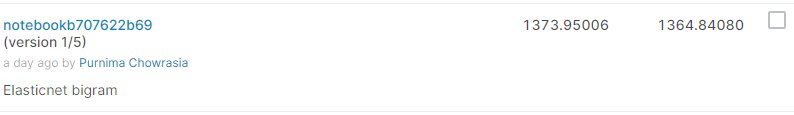

## 1.3 XgBoost

In [11]:
dtrain = xgb.DMatrix(train_bigram, y)
dtest = xgb.DMatrix(test_bigram)

In [23]:
#Defining Search Space: 
space = [Integer(2,10,name='max_depth'),Real(0,1,name='eta'),
        Real(0.5,1,name='subsample'),Real(0.5,1,name='colsample_bytree')]
@use_named_args(space)
def objective(**param):
    print(param)
    cv_result = xgb.cv(param, dtrain, seed=43, nfold=5, metrics='mae',num_boost_round=1000,early_stopping_rounds=10)
    mean_mae = cv_result['test-mae-mean'].min()
    return mean_mae

In [24]:
gp = gp_minimize(objective,space,n_calls=30,random_state=1, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
{'max_depth': 10, 'eta': 0.932557359338659, 'subsample': 0.5640622239646784, 'colsample_bytree': 0.9995202576620725}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.1102
Function value obtained: 0.5043
Current minimum: 0.5043
Iteration No: 2 started. Evaluating function at random point.
{'max_depth': 4, 'eta': 0.3965807272960262, 'subsample': 0.6939553705810038, 'colsample_bytree': 0.8348730184017401}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 148.0796
Function value obtained: 0.4626
Current minimum: 0.4626
Iteration No: 3 started. Evaluating function at random point.
{'max_depth': 9, 'eta': 0.8463109166860173, 'subsample': 0.6566367584661376, 'colsample_bytree': 0.7622740797864358}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.8381
Function value obtained: 0.4933
Current minimum: 0.4626
Iteration No: 4 started. Evaluating function at random point.
{'max

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 205.4565
Function value obtained: 0.4593
Current minimum: 0.4578
Iteration No: 29 started. Searching for the next optimal point.
{'max_depth': 2, 'eta': 0.7586755305143621, 'subsample': 1.0, 'colsample_bytree': 1.0}
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 127.2671
Function value obtained: 0.4611
Current minimum: 0.4578
Iteration No: 30 started. Searching for the next optimal point.
{'max_depth': 10, 'eta': 0.25980984181858985, 'subsample': 0.5, 'colsample_bytree': 1.0}
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 47.8429
Function value obtained: 0.4704
Current minimum: 0.4578


In [25]:
print('Max-depth: ', gp.x[0],' eta: ',gp.x[1],' Subsample: ',gp.x[2],'colsample_bytree: ', gp.x[3])

Max-depth:  5  eta:  0.20996784354003065  Subsample:  0.7011466306685964 colsample_bytree:  0.6725937575098012


In [26]:
gp.fun

0.45780899999999997

In [27]:
# Retraining on best Hyperparam:
params = {'max_depth': gp.x[0], 
        'eta': gp.x[1],
        'subsample':gp.x[2],
        'colsample_bytree':gp.x[3]}
model = xgb.train(params, dtrain, num_boost_round=1000)

In [28]:
pred = np.exp(model.predict(dtest))
submission['loss'] = pred
submission.to_csv('xgboost_bigram.csv',index=False)
submission.head()

,id,loss
0,4,1114.924438
1,6,2862.748535
2,9,9040.867188
3,12,6663.038086
4,15,783.109375


**Score obtained after submitting on kaggle:**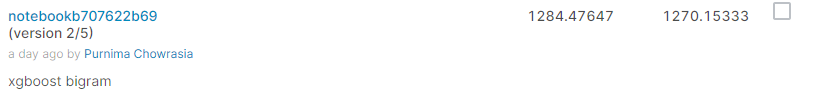

## 2. Trigram Feature(1000 features)
## 2.2 ElasticNet

In [7]:
skb = SelectKBest(k=1000, score_func=f_regression)
train_trigram = skb.fit_transform(train_trigram,y)
test_trigram = skb.transform(test_trigram)

print('Shape of train data:',train_trigram.shape)
print('Shape of test data:',test_trigram.shape)

Shape of train data: (188318, 1000)
Shape of test data: (125546, 1000)


In [8]:
scaler = MaxAbsScaler()
scaled_train = scaler.fit_transform(train_trigram)
scaled_test = scaler.transform(test_trigram)
print('Shape of train data:',scaled_train.shape)
print('Shape of test data:',scaled_test.shape)

Shape of train data: (188318, 1000)
Shape of test data: (125546, 1000)


In [11]:
space = [Real(0,1,name='l1_ratio'), Real(0.001,1000,prior='log-uniform', name='alpha')]
# Defining model
model = ElasticNet()
#https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html
@use_named_args(space)
def objective(**params):
    
    model.set_params(**params)
    score = cross_val_score(model,scaled_train, y, cv=5,n_jobs=-1,
                            scoring='neg_mean_absolute_error')
    return -np.mean(score)

#Optimizing all things together
gp = gp_minimize(objective,space,n_calls=20,random_state=1, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.6326
Function value obtained: 0.6600
Current minimum: 0.6600
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.4566
Function value obtained: 0.6600
Current minimum: 0.6600
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.0587
Function value obtained: 0.6461
Current minimum: 0.6461
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.9683
Function value obtained: 0.6600
Current minimum: 0.6461
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.6360
Function value obtained: 0.6600
Current minimum: 0.6461
Iteration No: 6 started. Evaluating

c:\purnima\myworkspace\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 443.1024
Function value obtained: 0.4685
Current minimum: 0.4685
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 16.5158
Function value obtained: 0.4747
Current minimum: 0.4685
Iteration No: 18 started. Searching for the next optimal point.


c:\purnima\myworkspace\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 463.0829
Function value obtained: 0.4685
Current minimum: 0.4685
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 18.3925
Function value obtained: 0.4834
Current minimum: 0.4685
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 445.4426
Function value obtained: 0.4689
Current minimum: 0.4685


In [12]:
print('l1-ratio: ',gp.x[0],' alpha: ',gp.x[1])

l1-ratio:  0.0  alpha:  0.001


In [13]:
gp.fun

0.46848949545336077

In [14]:
#Retraining on best hyperparameter:
model = ElasticNet(l1_ratio=0, alpha= 0.001, max_iter=1500)
model.fit(scaled_train,y)
pred = np.exp(model.predict(scaled_test))

c:\purnima\myworkspace\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34082.56869489034, tolerance: 12.412534702397357
  model = cd_fast.sparse_enet_coordinate_descent(


In [15]:
submission['loss'] = pred
submission.to_csv('Elasticnet_trigram.csv',index=False)
submission.head()

,id,loss
0,4,1483.584604
1,6,1833.916301
2,9,6621.892966
3,12,5897.530385
4,15,837.411425


**Score obtained after submitting on kaggle:**
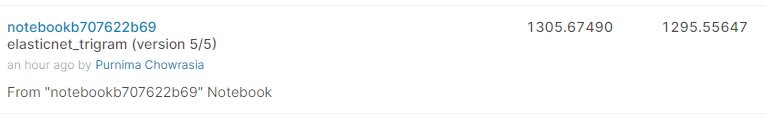

## 2.3 XgBoost

In [17]:
dtrain = xgb.DMatrix(train_trigram, y)
dtest = xgb.DMatrix(test_trigram)

In [18]:
#Defining Search Space: 
space = [Integer(2,10,name='max_depth'),Real(0,1,name='eta'),
        Real(0.5,1,name='subsample'),Real(0.5,1,name='colsample_bytree')]
@use_named_args(space)
def objective(**param):
    print(param)
    cv_result = xgb.cv(param, dtrain, seed=43, nfold=5, metrics='mae',num_boost_round=1000,early_stopping_rounds=10)
    mean_mae = cv_result['test-mae-mean'].min()
    return mean_mae

In [19]:
gp = gp_minimize(objective,space,n_calls=30,random_state=1, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
{'max_depth': 10, 'eta': 0.932557359338659, 'subsample': 0.5640622239646784, 'colsample_bytree': 0.9995202576620725}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 23.3262
Function value obtained: 0.4843
Current minimum: 0.4843
Iteration No: 2 started. Evaluating function at random point.
{'max_depth': 4, 'eta': 0.3965807272960262, 'subsample': 0.6939553705810038, 'colsample_bytree': 0.8348730184017401}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 127.0908
Function value obtained: 0.4467
Current minimum: 0.4467
Iteration No: 3 started. Evaluating function at random point.
{'max_depth': 9, 'eta': 0.8463109166860173, 'subsample': 0.6566367584661376, 'colsample_bytree': 0.7622740797864358}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 15.9921
Function value obtained: 0.4740
Current minimum: 0.4467
Iteration No: 4 started. Evaluating function at random point.
{'ma

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 257.6117
Function value obtained: 0.4436
Current minimum: 0.4431
Iteration No: 29 started. Searching for the next optimal point.
{'max_depth': 2, 'eta': 0.3135216254873704, 'subsample': 1.0, 'colsample_bytree': 1.0}
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 215.4357
Function value obtained: 0.4435
Current minimum: 0.4431
Iteration No: 30 started. Searching for the next optimal point.
{'max_depth': 2, 'eta': 0.5834632104916281, 'subsample': 0.5, 'colsample_bytree': 0.5}
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 88.2834
Function value obtained: 0.4508
Current minimum: 0.4431


In [20]:
print('Max-depth: ', gp.x[0],' eta: ',gp.x[1],' Subsample: ',gp.x[2],'colsample_bytree: ', gp.x[3])

Max-depth:  2  eta:  0.4631088649861478  Subsample:  1.0 colsample_bytree:  1.0


In [21]:
gp.fun

0.4430534

In [22]:
# Retraining on best Hyperparam:
params = {'max_depth': gp.x[0], 
        'eta': gp.x[1],
        'subsample':gp.x[2],
        'colsample_bytree':gp.x[3]}
model = xgb.train(params, dtrain, num_boost_round=1000)

In [23]:
pred = np.exp(model.predict(dtest))
submission['loss'] = pred
submission.to_csv('xgboost_trigram.csv',index=False)
submission.head()

,id,loss
0,4,1565.612427
1,6,2212.964600
2,9,5773.757812
3,12,5982.799316
4,15,794.446167


**Score obtained after submitting on kaggle:**
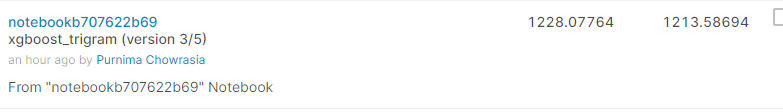

## Summary/Conclusion

After completeing the pre-processing part, next step is to apply some ML algorithms which is covered in this notebook. I worked with 2 sets of feature: one with bigrams(1000 features) and another with trigram(1000 features). Also Bayesian Optimization is used for hyperparameter tuning instead of GridSearchCV, because of Bayesian Optimization method is faster. Table below shows there performance and the score noted there is means absolute error:

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Feature Set', 'Model','Private Score']
x.add_row(['Bigram','Elastic-net','1373.95'])
x.add_row(['Bigram','xgboost','1284.47'])
x.add_row(['Trigram','Elastic-net','1305.67'])
x.add_row(['Trigram','xgboost','1228.07'])
print('Benchmark Score: ',1966,' mae')
print(x)

Benchmark Score:  1966  mae
+-------------+-------------+---------------+
| Feature Set |    Model    | Private Score |
+-------------+-------------+---------------+
|    Bigram   | Elastic-net |    1373.95    |
|    Bigram   |   xgboost   |    1284.47    |
|   Trigram   | Elastic-net |    1305.67    |
|   Trigram   |   xgboost   |    1228.07    |
+-------------+-------------+---------------+


* Trigram set Features performed better than bigram set.
* Xgboost always performed better than Elasticnet.
* Best performing model is xgboost with 1000 trigram set of features and kaggle score obtained is 1228.07 MAE.
* Future work that can be tried to imporve the scores are, deep learning models can be tried. Some more classical ML algorithms can also be applied. Some more new features can be improvised for example feature representing each points belonging to some kind of cluster.